In [1]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import umap
import scipy
import math
import time

In [3]:
#Get well level data, obtained by running downstream analysis
well_data_pd = pd.read_csv('./data/well_level_data_efn128new_qc_1e-2.csv')
columns = [str(i) for i in range(6400)]
well_data = well_data_pd[columns].to_numpy()
well_data_pd

,Plate,Well,Treatment,Replicate,broad_sample,0,1,2,3,4,...,6390,6391,6392,6393,6394,6395,6396,6397,6398,6399
0,20585,A01,BRD-K98763141-001-06-8@8.858401198,1,BRD-K98763141-001-06-8,0.259463,0.018787,-0.061246,0.010788,0.060735,...,0.024718,-0.312890,-0.131231,-0.002756,0.034718,0.759510,0.037973,0.016403,0.012713,0.292114
1,20585,A02,BRD-A41941932-001-03-0@2.312793797,1,BRD-A41941932-001-03-0,0.002958,-0.008202,-0.056054,0.175273,0.008627,...,0.024888,-0.073377,0.010274,-0.060285,-0.068509,0.368201,-0.000083,0.047193,0.030122,0.132456
2,20585,A03,BRD-A26711594-001-02-7@5.213492954,1,BRD-A26711594-001-02-7,0.060465,0.053497,0.066156,0.392154,0.017948,...,0.049251,0.003341,-0.018416,-0.052156,0.017464,-0.096254,0.002746,-0.010015,-0.058827,-0.120777
3,20585,A04,BRD-K65667145-001-05-8@4.646594864,1,BRD-K65667145-001-05-8,0.015015,-0.015315,-0.007618,0.215349,0.000748,...,0.026882,-0.052922,0.005645,-0.030978,-0.018452,0.583339,0.019042,-0.019768,0.031751,0.024102
4,20585,A05,BRD-K61250553-001-02-9@5.240677924,1,BRD-K61250553-001-02-9,0.068388,0.041297,-0.109480,0.487193,0.002305,...,0.021853,-0.069987,0.080281,-0.033992,-0.058877,0.874286,-0.005013,-0.017878,-0.014416,0.427596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7622,20646,P20,BRD-K16652251-001-02-7@5,4,BRD-K16652251-001-02-7,0.107225,0.028736,0.104407,0.352193,0.002630,...,0.088695,0.012951,0.136247,-0.002396,0.225839,-0.082546,-0.000953,-0.014823,0.080250,0.026845
7623,20646,P21,BRD-A26095496-001-02-4@5,4,BRD-A26095496-001-02-4,-0.016767,0.002465,0.151407,-0.093428,-0.007923,...,-0.038925,-0.004357,0.010786,-0.013168,-0.023368,0.062672,-0.000072,0.031951,-0.033318,-0.011849
7624,20646,P22,BRD-K46068882-001-02-7@5,4,BRD-K46068882-001-02-7,0.058097,-0.009860,-0.144237,-0.163729,-0.021809,...,0.008323,-0.039195,-0.010231,0.015650,0.003243,0.191453,0.016577,0.035091,-0.004903,0.246290
7625,20646,P23,BRD-K72166146-066-02-1@5,4,BRD-K72166146-066-02-1,0.026784,-0.011467,0.096905,0.210242,0.025021,...,-0.002279,0.010390,0.020149,-0.003095,-0.075602,0.238646,0.012600,0.023382,0.025263,-0.049547


# Run PCA

In [4]:
pca = PCA(.95)
pca = pca.fit(well_data)
pca_result = pca.transform(well_data)
useful_components = len(pca.explained_variance_ratio_[pca.explained_variance_ratio_ > 0.005])

<BarContainer object of 18 artists>

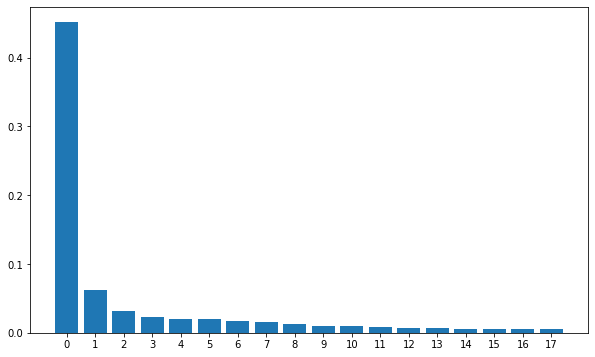

In [5]:
plt.figure(figsize=(10,6))
plt.xticks(range(useful_components))
plt.bar(height = pca.explained_variance_ratio_[:useful_components], x = range(len(pca.explained_variance_ratio_[:useful_components])))

In [6]:
b = well_data_pd[['Plate', 'Well', 'Treatment']].to_numpy()
a = np.column_stack((b, pca_result))[:,0:useful_components+3]

In [7]:
columns_pca = ['PCA ' + str(i) for i in range(1,useful_components+1)]
principalDf = pd.DataFrame(data = a, columns = ['Plate', 'Well','Treatment'] + columns_pca)
principalDf['control'] = principalDf['Treatment'] == 'DMSO@0'
for i in range(1, useful_components+1):
    principalDf['PCA {}'.format(i)] = principalDf['PCA {}'.format(i)].astype('float32')

<Figure size 864x864 with 0 Axes>

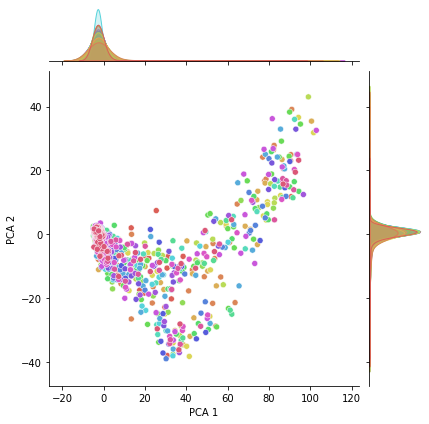

<Figure size 864x864 with 0 Axes>

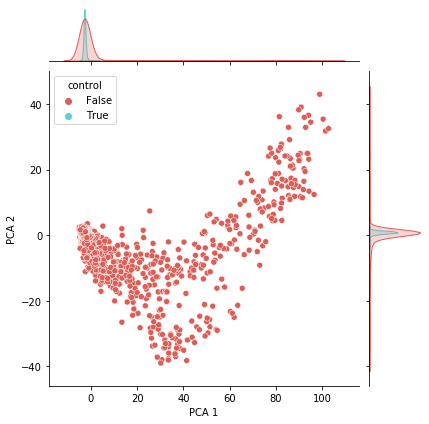

<Figure size 864x864 with 0 Axes>

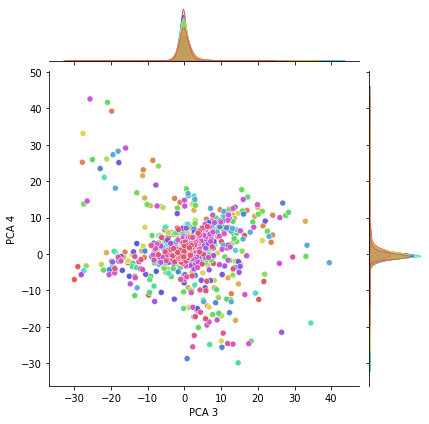

<Figure size 864x864 with 0 Axes>

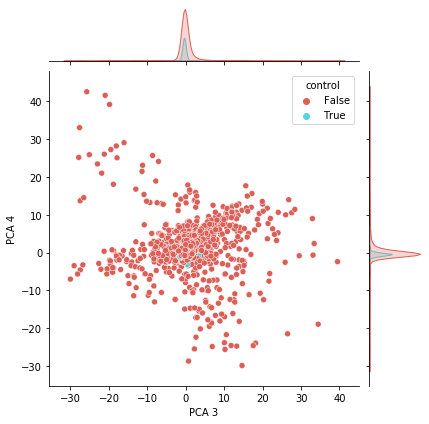

<Figure size 864x864 with 0 Axes>

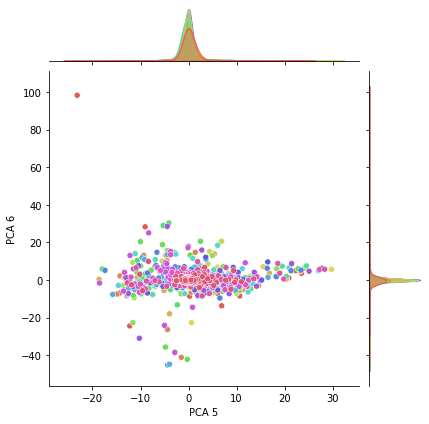

<Figure size 864x864 with 0 Axes>

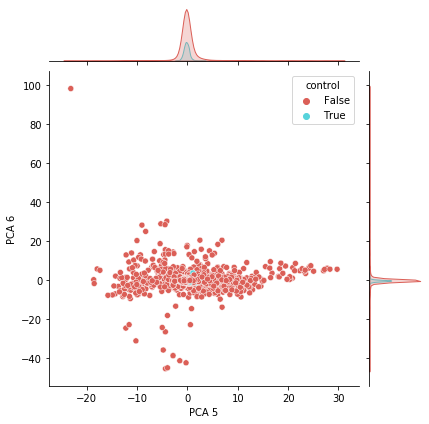

<Figure size 864x864 with 0 Axes>

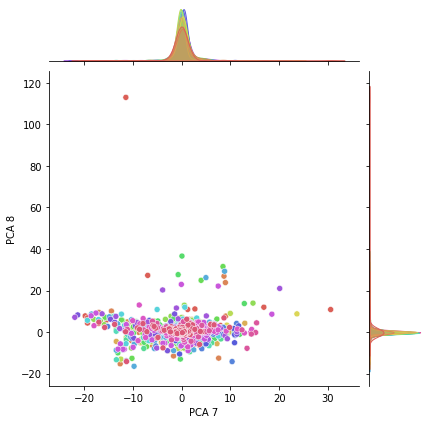

<Figure size 864x864 with 0 Axes>

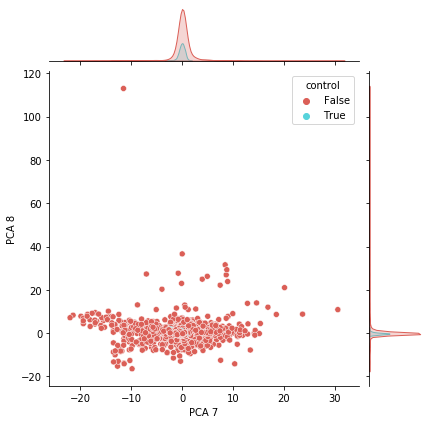

<Figure size 864x864 with 0 Axes>

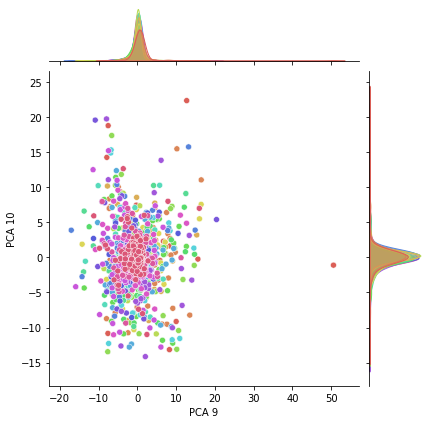

<Figure size 864x864 with 0 Axes>

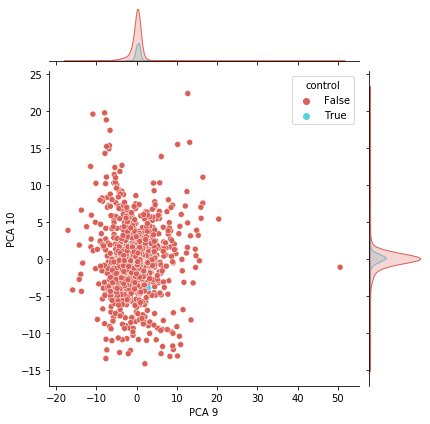

<Figure size 864x864 with 0 Axes>

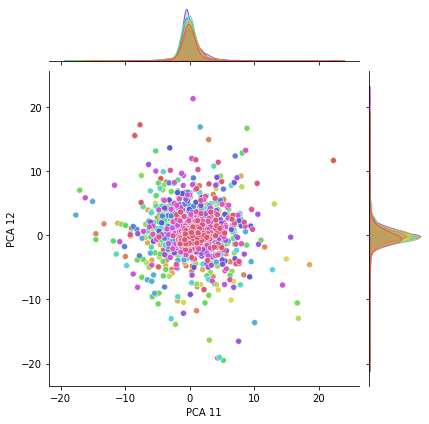

<Figure size 864x864 with 0 Axes>

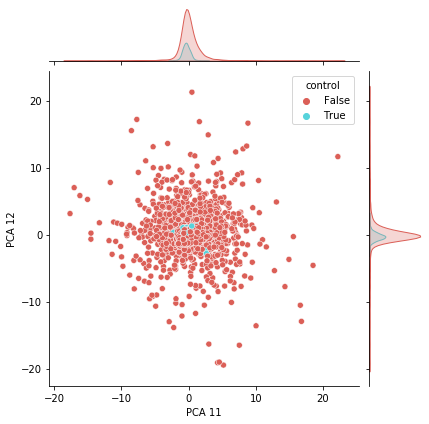

<Figure size 864x864 with 0 Axes>

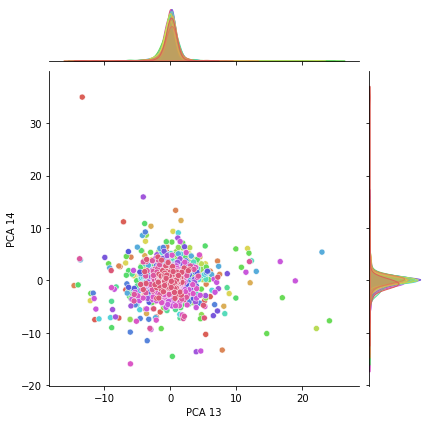

<Figure size 864x864 with 0 Axes>

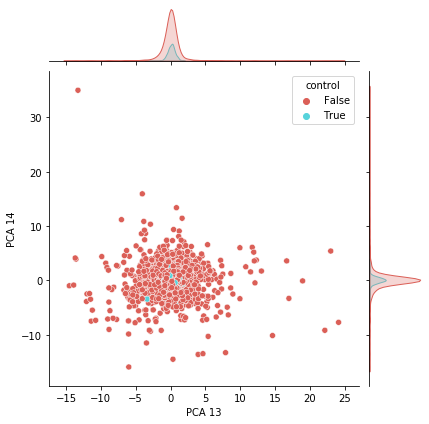

<Figure size 864x864 with 0 Axes>

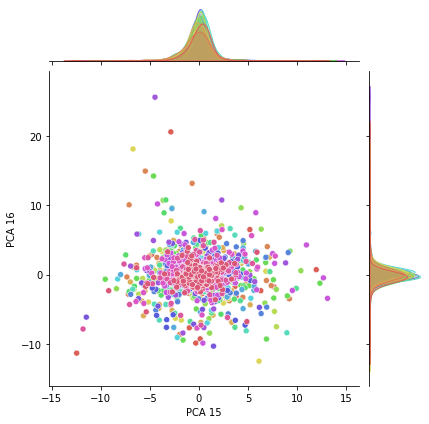

<Figure size 864x864 with 0 Axes>

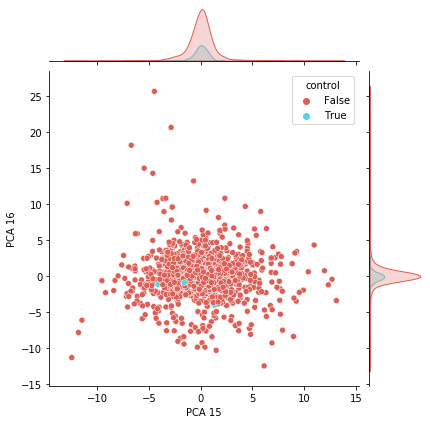

<Figure size 864x864 with 0 Axes>

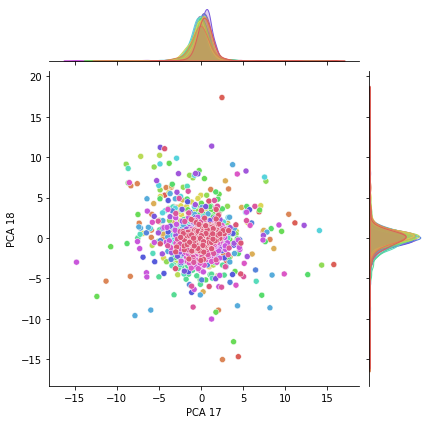

<Figure size 864x864 with 0 Axes>

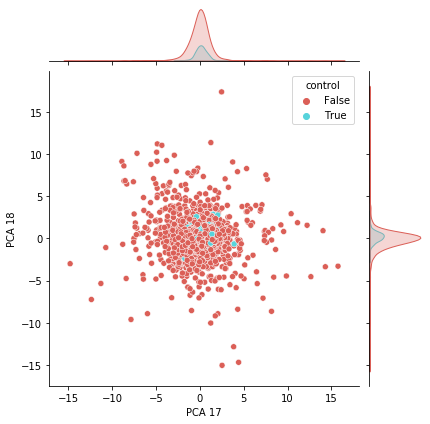

In [8]:
to_plot = useful_components - useful_components % 2
for i in range(1, to_plot, 2):
    plt.figure(figsize=(12,12))
    color = sb.color_palette("hls", 20)
    sb.jointplot(data = principalDf, x="PCA {}".format(i), y="PCA {}".format(i+1), palette=color, hue = 'Plate', legend=False)
    plt.show()
    plt.figure(figsize=(12,12))
    color = sb.color_palette("hls", 2)
    sb.jointplot(data = principalDf, x="PCA {}".format(i), y="PCA {}".format(i+1), palette=color, hue = 'control')
    plt.show()


# Run UMAP

In [9]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(well_data)
principalDf = pd.concat((pd.DataFrame(embeddings, columns=["UMAP 1", "UMAP 2"]), principalDf.reset_index(drop=True)), axis=1)

In [10]:
principalDf.reset_index(drop=True, inplace = True)

<Figure size 864x864 with 0 Axes>

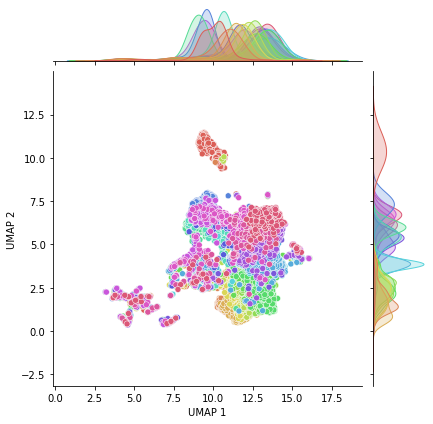

<Figure size 864x864 with 0 Axes>

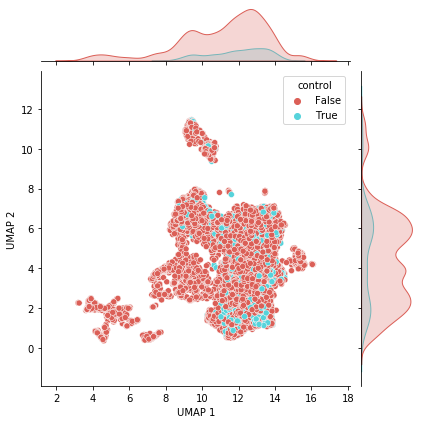

In [11]:
plt.figure(figsize=(12,12))
color = sb.color_palette("hls", 20)
sb.jointplot(data = principalDf, x="UMAP 1", y="UMAP 2", palette=color, hue = 'Plate', legend = False)
plt.figure(figsize=(12,12))
color = sb.color_palette("hls", 2)
sb.jointplot(data = principalDf, x="UMAP 1", y="UMAP 2", palette=color, hue = 'control')

# Calculate correlations of individiaul wells vs median plate profile of DMSO control

In [12]:
median_controls = well_data_pd[well_data_pd['Treatment'] == 'DMSO@0'].drop(columns=['Treatment','Replicate']).groupby(["Plate"]).median().reset_index()

In [13]:
correlations_df = pd.DataFrame(columns=['Plate', 'Well', 'Treatment', 'Replicate', 'control_corr'])
for i in tqdm(well_data_pd.index):
    well_profile = well_data_pd.loc[i, columns].to_numpy()
    plate_control_profile = median_controls[median_controls['Plate'] == well_data_pd.loc[i, 'Plate']][columns].to_numpy()[0]
    correlations_df.loc[i] = [  well_data_pd.loc[i, 'Plate'],  well_data_pd.loc[i, 'Well'],  well_data_pd.loc[i, 'Treatment'],  well_data_pd.loc[i, 'Replicate'], scipy.stats.pearsonr(well_profile, plate_control_profile)[0] ]

100%|██████████| 7627/7627 [02:52<00:00, 44.11it/s]


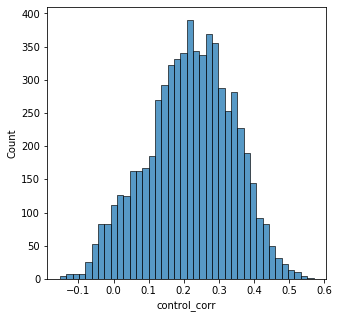

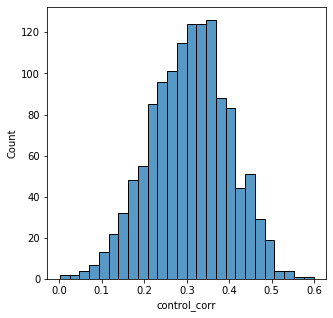

In [14]:
#plot distribution of correlations without controls
plt.figure(figsize=(5,5))
sb.histplot(correlations_df[~correlations_df['Treatment'].isin(['DMSO@0'])]['control_corr'])
plt.figure(figsize=(5,5))
sb.histplot(correlations_df[correlations_df['Treatment'].isin(['DMSO@0'])]['control_corr'])

In [15]:
principalDf = pd.merge(correlations_df, principalDf, right_on = ['Plate', 'Well', 'Treatment'], left_on = ['Plate', 'Well', 'Treatment'] )
principalDf

,Plate,Well,Treatment,Replicate,control_corr,UMAP 1,UMAP 2,PCA 1,PCA 2,PCA 3,...,PCA 10,PCA 11,PCA 12,PCA 13,PCA 14,PCA 15,PCA 16,PCA 17,PCA 18,control
0,20585,A01,BRD-K98763141-001-06-8@8.858401198,1,-0.060890,11.355791,4.399403,13.376032,2.006020,-9.770265,...,-0.426385,-7.709152,17.200563,-2.085438,-6.959754,5.203903,6.521304,-4.302265,5.306505,False
1,20585,A02,BRD-A41941932-001-03-0@2.312793797,1,0.188101,9.129851,10.725540,1.314993,0.204715,1.385251,...,-2.362487,1.530131,2.729145,-1.810442,-3.709607,0.718528,-2.029765,0.484905,-1.165660,False
2,20585,A03,BRD-A26711594-001-02-7@5.213492954,1,0.095779,9.058385,10.844146,3.108745,-1.189957,0.814331,...,-0.941795,-0.173173,3.377115,-0.938152,-3.348337,0.335294,-2.732665,0.467333,-2.245987,False
3,20585,A04,BRD-K65667145-001-05-8@4.646594864,1,0.223883,9.112360,10.915796,0.194026,0.251329,-0.404575,...,0.642825,0.090918,1.333507,-0.640495,-0.974410,1.340881,-1.870406,-0.048793,-1.022286,False
4,20585,A05,BRD-K61250553-001-02-9@5.240677924,1,0.218483,9.222093,10.580457,0.233108,-3.074933,4.735920,...,-0.454452,0.128421,0.704384,-2.256011,-4.003273,-1.055466,-1.267097,0.618937,-1.596928,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7622,20646,P20,BRD-K16652251-001-02-7@5,4,0.150442,9.355688,3.288435,0.242302,-3.859911,1.344896,...,-0.981242,6.533500,2.506929,0.189528,-0.167644,0.467651,-0.328932,0.304333,-0.460298,False
7623,20646,P21,BRD-A26095496-001-02-4@5,4,0.253716,15.269344,4.758112,-3.804312,0.550786,-0.116620,...,-0.823625,2.816950,-0.312627,-0.596826,0.390341,2.493503,0.969200,-2.411673,0.082628,False
7624,20646,P22,BRD-K46068882-001-02-7@5,4,0.138535,12.663189,5.857453,-3.365035,0.711476,-0.712700,...,-0.773474,2.220184,-0.017887,0.164608,-1.333033,-0.297038,0.821973,-0.884656,-0.016328,False
7625,20646,P23,BRD-K72166146-066-02-1@5,4,0.240809,12.817813,6.829804,-4.511911,1.652637,-0.235630,...,-0.345168,1.287132,0.357660,-0.816540,-0.966683,1.072355,0.765246,-0.807001,-0.978419,False


# Selection of the candidates based on PCA

In [16]:
plates_wells = []
for pca_c in range(1,useful_components+1):
    median_pca = principalDf[principalDf['Treatment']=='DMSO@0']['PCA {}'.format(pca_c)].median()
    temp = []
    for i in principalDf.index:
        temp.append(abs(median_pca - principalDf.loc[i, 'PCA {}'.format(pca_c)]))
    
    idx = (-np.array(temp)).argsort()[:int(round(len(temp)*pca.explained_variance_ratio_[pca_c-1]))]
    for idd in idx:
        plates_wells.append((principalDf.loc[idd, 'Plate'], principalDf.loc[idd, 'Well'] )) 

In [17]:
len(set(plates_wells))

3460

# Selection of the candidates based on UMAP

(array([ 20.,  55.,  85., 151., 196., 247., 294., 330., 378., 383., 389.,
        424., 450., 411., 344., 400., 457., 337., 390., 363., 286., 208.,
         98.,  29.,  35.,  46.,  14.,  10.,  26.,  29.,  69.,  61.,   8.,
         22.,  33.,  63.,  50.,  27.,  56.,  71.,  24.,  29.,  21.,  20.,
         18.,  29.,  56.,  71.,   6.,   8.]),
 array([0.07352394, 0.2533232 , 0.43312246, 0.61292173, 0.79272099,
        0.97252025, 1.15231951, 1.33211877, 1.51191804, 1.6917173 ,
        1.87151656, 2.05131582, 2.23111509, 2.41091435, 2.59071361,
        2.77051287, 2.95031214, 3.1301114 , 3.30991066, 3.48970992,
        3.66950918, 3.84930845, 4.02910771, 4.20890697, 4.38870623,
        4.5685055 , 4.74830476, 4.92810402, 5.10790328, 5.28770254,
        5.46750181, 5.64730107, 5.82710033, 6.00689959, 6.18669886,
        6.36649812, 6.54629738, 6.72609664, 6.90589591, 7.08569517,
        7.26549443, 7.44529369, 7.62509295, 7.80489222, 7.98469148,
        8.16449074, 8.34429   , 8.52408927, 8.

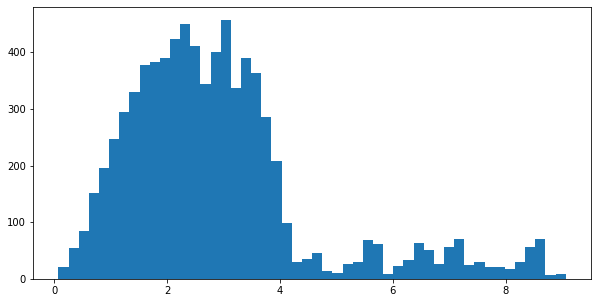

In [18]:
#for UMAP calculate mean point for EMPTY, and calculate distances 
#for all wells and additionally for EMPTY wells (to calculate average distance)
mean_umap1 = principalDf[principalDf['Treatment']=='DMSO@0']['UMAP 1'].mean()
mean_umap2 = principalDf[principalDf['Treatment']=='DMSO@0']['UMAP 2'].mean()
temp = []
temp_empty = []
for i in principalDf.index:
    temp.append(scipy.spatial.distance.euclidean([mean_umap1, mean_umap2], [principalDf.loc[i, 'UMAP 1'], principalDf.loc[i, 'UMAP 2']]))
    if principalDf.loc[i, 'Treatment'] =='DMSO@0':
        temp_empty.append(scipy.spatial.distance.euclidean([mean_umap1, mean_umap2], [principalDf.loc[i, 'UMAP 1'], principalDf.loc[i, 'UMAP 2']]))

plt.figure(figsize=(10,5))
plt.hist(temp, bins=50)

In [19]:
#The arbitary selection here would be to select wells with the distance which exceeds the 95th percentile distance of EMPTY
#append to existing array to plates_wells
idx = list(np.argwhere(np.array(temp) > np.percentile(temp_empty, 95)).flatten())
for idd in idx:
    plates_wells.append((principalDf.loc[idd, 'Plate'], principalDf.loc[idd, 'Well'] )) 


In [20]:
len(set(plates_wells))

3621

# Selection of the candidates based on correlations (skip it)

In [21]:
#Get the well with correlation value below 5th percentile of the correlations inside
'''
idx = list(principalDf[principalDf['control_corr'] < np.percentile(principalDf[principalDf['Treatment'] == 'DMSO@0']['control_corr'], 5)].index)
for idd in idx:
    plates_wells.append((principalDf.loc[idd, 'Plate'], principalDf.loc[idd, 'Well'] ))
'''   


"\nidx = list(principalDf[principalDf['control_corr'] < np.percentile(principalDf[principalDf['Treatment'] == 'DMSO@0']['control_corr'], 5)].index)\nfor idd in idx:\n    plates_wells.append((principalDf.loc[idd, 'Plate'], principalDf.loc[idd, 'Well'] ))\n"

# Get final candidates

In [25]:
candidates = pd.DataFrame(set(plates_wells), columns =['Plate', 'Well'])
candidates = pd.merge(candidates, principalDf, right_on = ['Plate', 'Well'], left_on = ['Plate', 'Well'] )
candidates

,Plate,Well,Treatment,Replicate,control_corr,UMAP 1,UMAP 2,PCA 1,PCA 2,PCA 3,...,PCA 10,PCA 11,PCA 12,PCA 13,PCA 14,PCA 15,PCA 16,PCA 17,PCA 18,control
0,20586,P10,BRD-K01292756-001-06-0@5.416576243,1,0.023170,4.621119,1.932997,60.864708,-2.583515,23.629852,...,5.427362,1.128253,-7.998037,7.180733,3.702723,3.104262,-3.772866,2.542627,-15.034211,False
1,20586,F16,BRD-K16604360-001-01-8@5,1,-0.000925,3.871187,2.452294,90.965454,39.096703,-19.845657,...,-7.258420,11.582873,-1.832025,-4.542588,0.818944,-7.113549,10.091095,10.410010,2.936513,False
2,20646,H01,BRD-K54411430-001-02-5@5,4,0.064107,12.510602,6.368588,-1.361452,-0.447805,0.700699,...,-0.422187,1.839902,0.988341,-1.305594,-1.725347,-0.740562,0.179215,-0.367839,-1.488082,False
3,20625,D10,BRD-K05673000-323-02-8@1.955678727,3,0.399749,9.921109,7.335053,-3.279938,0.538180,-0.444515,...,1.261993,-0.730911,-1.146007,0.077589,0.606326,-0.693202,-0.503230,0.613495,0.124838,False
4,20596,A04,BRD-K88849294-001-02-1@5,2,0.179282,10.549622,5.071581,-3.696760,0.987137,-0.796628,...,-1.203166,0.918418,0.214329,0.014978,-0.376042,-0.252439,0.072594,-1.122511,-1.961626,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3616,20630,K08,DMSO@0,938,0.207154,13.567319,5.864450,-2.268575,1.177967,0.244679,...,0.070247,-0.977728,-0.123333,-0.631735,-0.072908,0.513942,-0.214352,0.962090,0.370849,True
3617,20646,F19,BRD-K44899736-003-02-1@5,4,0.334701,13.716507,6.614785,-3.583625,1.202886,0.002224,...,1.188990,0.512943,0.126123,-0.033866,-0.295031,-0.175492,0.853602,0.108539,0.042369,False
3618,20595,A06,BRD-A71774530-001-01-8@5,2,0.144631,8.375023,5.914876,-0.200344,-1.178219,2.446387,...,1.015527,0.158565,1.532305,-0.091286,-3.946990,-2.148307,-0.405311,0.038425,-3.046617,False
3619,20596,I07,BRD-A27887842-001-02-4@5,2,0.362341,15.545105,4.295953,-3.202971,0.315869,-0.096613,...,0.037140,1.708627,0.286274,-1.243082,1.110569,1.896148,1.283105,-1.568887,-0.257838,False


# Final clean-up

In [26]:
#remove controls from candidates and mismatch\truncated
candidates = candidates[~candidates['Treatment'].isin(['DMSO@0'])]
candidates

,Plate,Well,Treatment,Replicate,control_corr,UMAP 1,UMAP 2,PCA 1,PCA 2,PCA 3,...,PCA 10,PCA 11,PCA 12,PCA 13,PCA 14,PCA 15,PCA 16,PCA 17,PCA 18,control
0,20586,P10,BRD-K01292756-001-06-0@5.416576243,1,0.023170,4.621119,1.932997,60.864708,-2.583515,23.629852,...,5.427362,1.128253,-7.998037,7.180733,3.702723,3.104262,-3.772866,2.542627,-15.034211,False
1,20586,F16,BRD-K16604360-001-01-8@5,1,-0.000925,3.871187,2.452294,90.965454,39.096703,-19.845657,...,-7.258420,11.582873,-1.832025,-4.542588,0.818944,-7.113549,10.091095,10.410010,2.936513,False
2,20646,H01,BRD-K54411430-001-02-5@5,4,0.064107,12.510602,6.368588,-1.361452,-0.447805,0.700699,...,-0.422187,1.839902,0.988341,-1.305594,-1.725347,-0.740562,0.179215,-0.367839,-1.488082,False
3,20625,D10,BRD-K05673000-323-02-8@1.955678727,3,0.399749,9.921109,7.335053,-3.279938,0.538180,-0.444515,...,1.261993,-0.730911,-1.146007,0.077589,0.606326,-0.693202,-0.503230,0.613495,0.124838,False
4,20596,A04,BRD-K88849294-001-02-1@5,2,0.179282,10.549622,5.071581,-3.696760,0.987137,-0.796628,...,-1.203166,0.918418,0.214329,0.014978,-0.376042,-0.252439,0.072594,-1.122511,-1.961626,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3615,20593,M12,BRD-K77987382-001-06-6@3.386470212,2,-0.045267,4.435108,0.515304,36.490246,-35.945938,-8.844670,...,4.437395,2.941332,-9.351587,-3.978662,3.636312,2.189881,-2.846872,0.066237,3.659977,False
3617,20646,F19,BRD-K44899736-003-02-1@5,4,0.334701,13.716507,6.614785,-3.583625,1.202886,0.002224,...,1.188990,0.512943,0.126123,-0.033866,-0.295031,-0.175492,0.853602,0.108539,0.042369,False
3618,20595,A06,BRD-A71774530-001-01-8@5,2,0.144631,8.375023,5.914876,-0.200344,-1.178219,2.446387,...,1.015527,0.158565,1.532305,-0.091286,-3.946990,-2.148307,-0.405311,0.038425,-3.046617,False
3619,20596,I07,BRD-A27887842-001-02-4@5,2,0.362341,15.545105,4.295953,-3.202971,0.315869,-0.096613,...,0.037140,1.708627,0.286274,-1.243082,1.110569,1.896148,1.283105,-1.568887,-0.257838,False


(array([440.,   0.,   0., 888.,   0.,   0., 897.,   0.,   0., 936.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

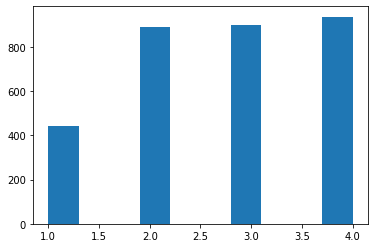

In [27]:
plt.hist(candidates['Treatment'].map(candidates['Treatment'].value_counts()))

In [28]:
#remove the perturbations with less than 3 replicates left out of 4
candidates = candidates[candidates['Treatment'].map(candidates['Treatment'].value_counts()) > 2]
candidates['Treatment'].value_counts()

BRD-A45889380-336-03-4@1.96498692     4
BRD-K63793181-001-02-6@0.316149903    4
BRD-K00141480-001-03-0@8.493451311    4
BRD-K84595254-001-03-0@2.472208789    4
BRD-K54728231-001-02-3@5              4
                                     ..
BRD-K29582677-001-02-7@6.18054846     3
BRD-K30197592-001-01-5@5              3
BRD-K47328134-001-02-0@5              3
BRD-K72166146-066-02-1@5              3
BRD-K79759585-001-02-1@5              3
Name: Treatment, Length: 533, dtype: int64

In [29]:
len(candidates['Treatment'].unique())

533

In [31]:
len(well_data_pd['Treatment'].unique())

1598

In [32]:
candidates.to_csv('bbbc022_candidates.csv')